In [2]:
from __future__ import print_function, division
%matplotlib notebook
import brainweb
from brainweb import volshow
import numpy as np
from os import path
from tqdm.auto import tqdm
import logging
logging.basicConfig(level=logging.INFO)
import nibabel as nib
import sirf.STIR as pet
import matplotlib.pyplot as plt
import os

os.chdir("/Users/rich/Documents/Data/brainweb/")
# download
# files = brainweb.get_files(".")
# file = [0]
file = "subject_04.bin.gz"
# read first
data = brainweb.load_file(file)


In [3]:
brainweb.seed(1337)

for f in tqdm([file], desc="mMR ground truths", unit="subject"):
    vol = brainweb.get_mmr_fromfile(
        f,
        petNoise=1, t1Noise=0.75, t2Noise=0.75,
        petSigma=1, t1Sigma=1, t2Sigma=1)

subject_04.bin.gz


<IPython.core.display.Javascript object>


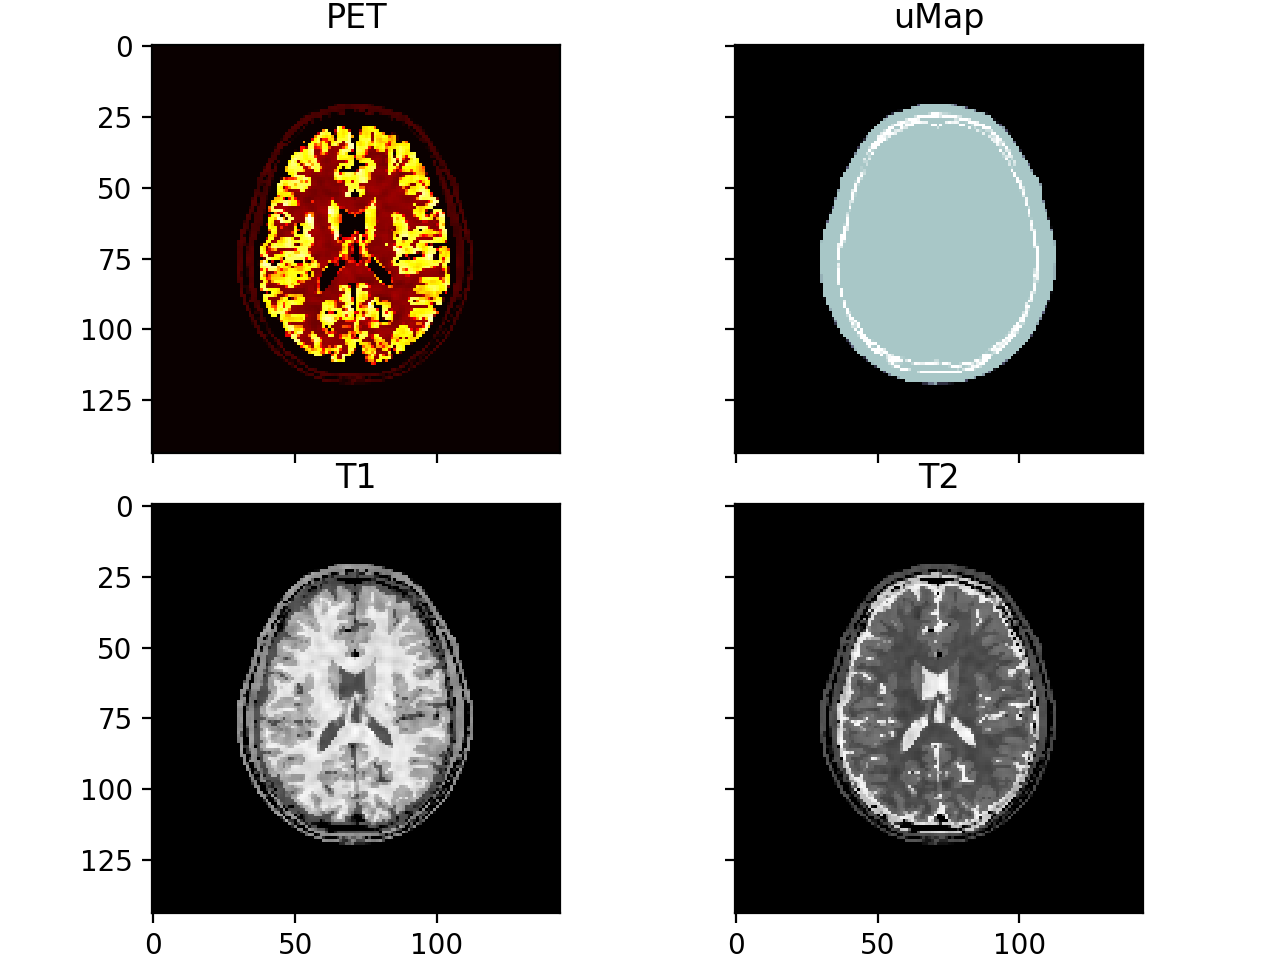

interactive(children=(IntSlider(value=63, description='z', max=126), Output()), _dom_classes=('widget-interact…

In [4]:
print(f)
volshow([vol['PET' ][:, 100:-100, 100:-100],
         vol['uMap'][:, 100:-100, 100:-100],
         vol['T1'  ][:, 100:-100, 100:-100],
         vol['T2'  ][:, 100:-100, 100:-100]],
        cmaps=['hot', 'bone', 'Greys_r', 'Greys_r'],
        titles=["PET", "uMap", "T1", "T2"]);

<IPython.core.display.Javascript object>


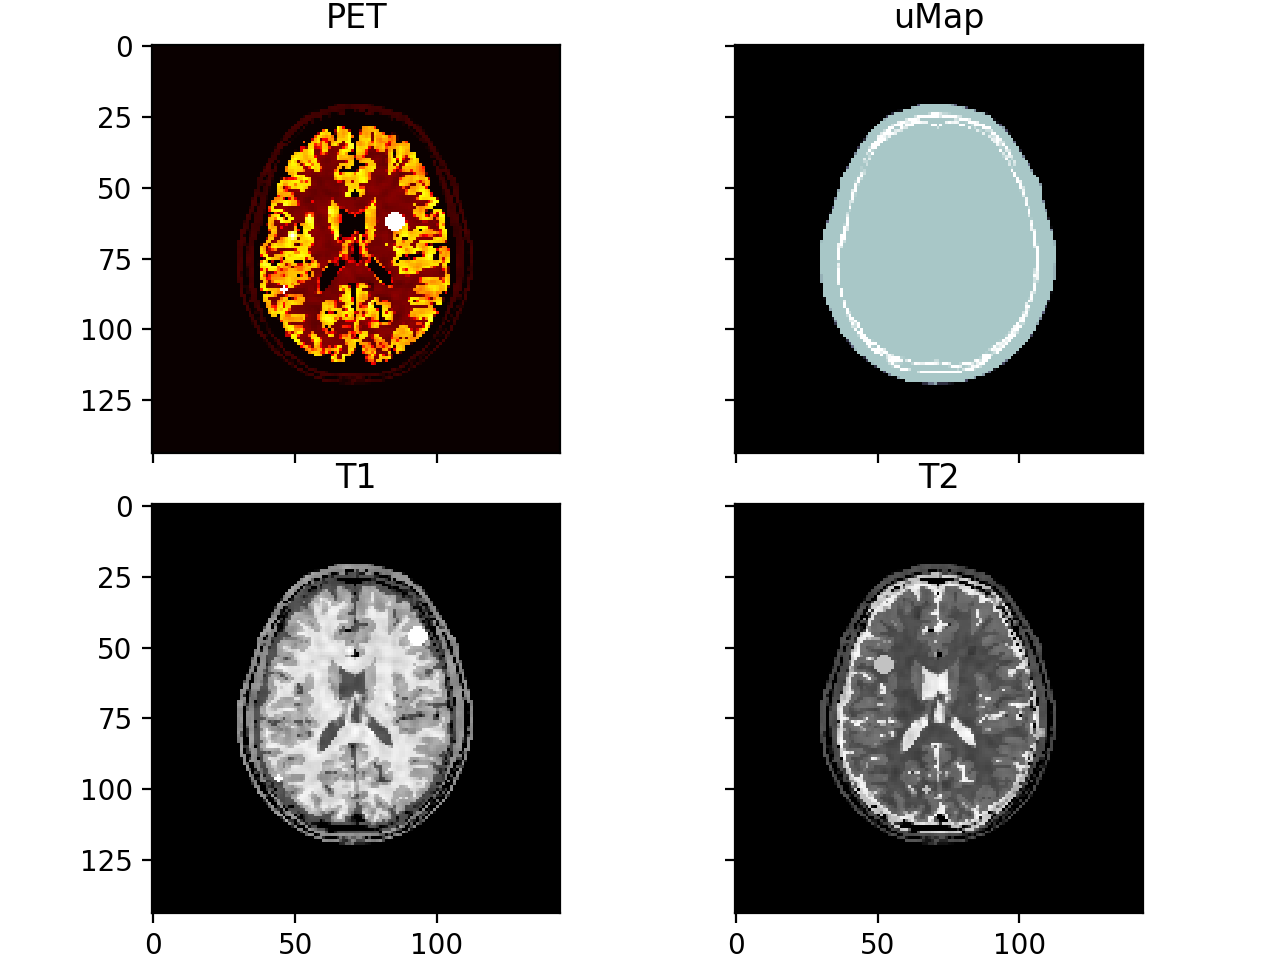

interactive(children=(IntSlider(value=63, description='z', max=126), Output()), _dom_classes=('widget-interact…

In [7]:
# add some lesions
brainweb.seed(1339)
# PET_tumour = brainweb.add_lesions(vol['PET']) 
# T1_tumour = brainweb.add_lesions(vol['T1'])
# T2_tumour = brainweb.add_lesions(vol['T2'])

volshow([PET_tumour[:, 100:-100, 100:-100],
         vol['uMap'][:, 100:-100, 100:-100],
         T1_tumour  [:, 100:-100, 100:-100],
         T2_tumour  [:, 100:-100, 100:-100]],
        cmaps=['hot', 'bone', 'Greys_r', 'Greys_r'],
        titles=["PET", "uMap", "T1", "T2"]);

## Save as STIR interfile

In [11]:
# We'll need a template sinogram
import sirf.STIR as pet
templ_sino = pet.AcquisitionData('mMR_template_span11_small.hs')

def crop_image(vol):
    return vol[:,17:17+285,17:17+285]

def save_as_interfile(templ_sino, vol, fname):
    # Crop to (127,285,285)
    vol = crop_image(vol)
    im = pet.ImageData(templ_sino)
    im.fill(vol)
    im.write(fname)

save_as_interfile(templ_sino, vol['PET'], "subj_04_PET")
save_as_interfile(templ_sino, vol['uMap'],"subj_04_uMap")
save_as_interfile(templ_sino, vol['T1'],  "subj_04_T1")
save_as_interfile(templ_sino, vol['T2'],  "subj_04_T2")
save_as_interfile(templ_sino, PET_tumour, "subj_04_PET_tumour")
save_as_interfile(templ_sino, T1_tumour,  "subj_04_T1_tumour")
save_as_interfile(templ_sino, T2_tumour,  "subj_04_T2_tumour")

## Forward project

In [14]:
# We'll need a template sinogram
templ_sino = pet.AcquisitionData('mMR_template_span11_small.hs')

# Attenuation from template
gt_atten = pet.ImageData(templ_sino)
gt_atten.fill(crop_image(vol['uMap']))

#%% create acquisition model
am = pet.AcquisitionModelUsingRayTracingMatrix()
am.set_num_tangential_LORs(5)

# Set up sensitivity due to attenuation
asm_attn = pet.AcquisitionSensitivityModel(gt_atten, am)
asm_attn.set_up(templ_sino)
bin_eff = pet.AcquisitionData(templ_sino)
bin_eff.fill(1.0)
print('applying attenuation (please wait, may take a while)...')
asm_attn.unnormalise(bin_eff)
asm_attn = pet.AcquisitionSensitivityModel(bin_eff)

am.set_acquisition_sensitivity(asm_attn)

am.set_up(templ_sino,gt_atten);

applying attenuation (please wait, may take a while)...


In [16]:
def fwd_prj(am,vol,template_im,add_noise):
    image = template_im.clone()
    image.fill(vol)
    proj_data = am.forward(image)
    if add_noise:
        proj_data_arr = np.abs(proj_data.as_array());
        noisy_array = np.random.poisson(proj_data_arr).astype('float32');
        proj_data.fill(noisy_array);
    return proj_data

## Do PET data w and w/o tumour and w and w/o noise

In [19]:
sino_PET = fwd_prj(am,crop_image(vol['PET']),gt_atten,False)
sino_PET.write("subj_04_sino")

In [20]:
sino_PET_tumour = fwd_prj(am,crop_image(PET_tumour),gt_atten,False)
sino_PET_tumour.write("subj_04_sino_tumour")

In [21]:
sino_PET_noisy = fwd_prj(am,crop_image(vol['PET']),gt_atten,True)
sino_PET_noisy.write("subj_04_sino_noisy")

In [22]:
sino_PET_noisy_tumour = fwd_prj(am,crop_image(PET_tumour),gt_atten,True)
sino_PET_noisy_tumour.write("/Users/rich/Documents/Data/brainweb/subj_04_sino_noisy_tumour")

## Use single slice rebinning (SSRB) in STIR to get 2D sinograms

In [ ]:
def get_2d_sino(input_sino):
    vxc
    xcv
    cxv
    xc
    cx
    v
    xcv
    c